# Perez Data Inspection

#### Date: 17Jan2024
#### Author: Jrose


Here I am looking at the Andata object retreieved from ()[https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE174188]

This data is from Perez et al. Science 2022. It includes 1.2 million PBMC from 162 SLE and 99 HC adult individuals

In [1]:
import scanpy as sc
import os

data_dir="../data/Perez"
file="GSE174188_CLUES1_adjusted.h5ad"

adata_path = os.path.join(data_dir, file)

adata = sc.read(adata_path)


/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [2]:
adata

AnnData object with n_obs × n_vars = 1263676 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

I'm now going to go through this object, keeping only the B cells and then doing some routine checks on the quality of the remaining cells

In [3]:
adata.obs['ct_cov'].value_counts()

ct_cov
T4_naive       207629
B_naive         95726
T4_em           86979
CytoT_GZMH+     82466
NK_dim          74995
T8_naive        72202
CytoT_GZMK+     56218
B_mem           40804
T4_reg          31610
T_mait          14284
NK_bright       13352
Progen          12202
B_atypical       4205
B_plasma         1201
Name: count, dtype: int64

In [4]:
adata.obs['cg_cov'].value_counts()

cg_cov
T4        380477
cM        307429
T8        248927
B         151570
NK         92554
ncM        48800
cDC        18203
Prolif      8265
pDC         5233
PB          1411
Progen       807
Name: count, dtype: int64

## Get the raw count data

In [5]:
raw_adata = sc.AnnData(adata.raw.X)
raw_adata.var_names = adata.raw.var_names
raw_adata.obs_names = adata.obs_names

raw_adata.obs = adata.obs.copy()
raw_adata.var = adata.raw.var.copy()

In [6]:
raw_adata

AnnData object with n_obs × n_vars = 1263676 × 32738
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids', 'feature_types-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0'

## Select out the B cells

In [7]:
Bmask = (raw_adata.obs['cg_cov']=='B') | (raw_adata.obs['cg_cov']=='PB')

B_adata = raw_adata[Bmask, :]

In [8]:
B_adata

View of AnnData object with n_obs × n_vars = 152981 × 32738
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids', 'feature_types-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0'

In [9]:
B_adata.obs['cg_cov'].value_counts()

cg_cov
B     151570
PB      1411
Name: count, dtype: int64

## Checking the data

/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


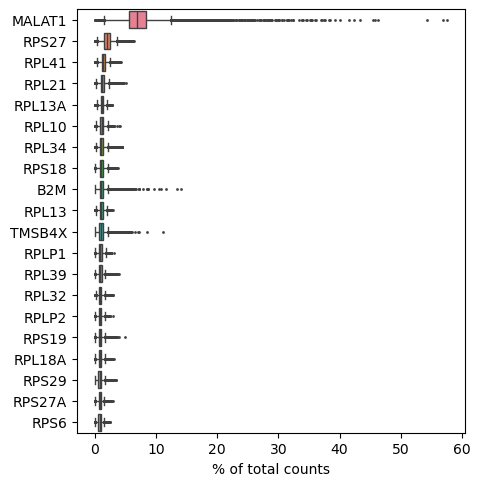

In [10]:
sc.pl.highest_expr_genes(B_adata, n_top=20, )

In [11]:
B_adata.var['mt'] = B_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(B_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [12]:
#sc.pl.violin(B_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#             jitter=0.4, multi_panel=True)
#Broken fro some reason

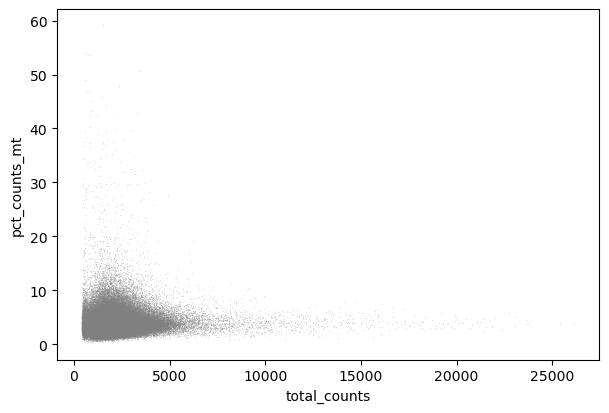

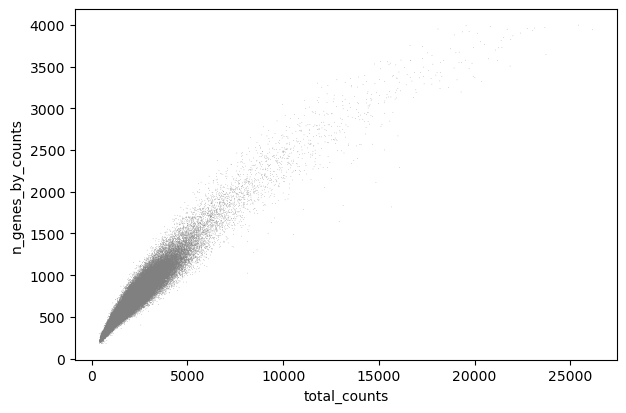

In [13]:
sc.pl.scatter(B_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(B_adata, x='total_counts', y='n_genes_by_counts')

<Axes: xlabel='cg_cov', ylabel='pct_counts_mt'>

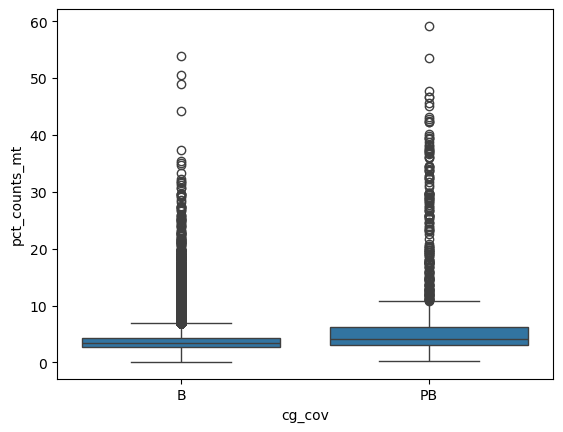

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='cg_cov', y='pct_counts_mt', data=B_adata.obs)

In [15]:
sc.pp.filter_cells(B_adata, min_genes=200)
sc.pp.filter_genes(B_adata, min_cells=3)

B_adata = B_adata[B_adata.obs.n_genes_by_counts < 2500, :]
#Being much more permissive on MT since PB have more MT in general
B_adata = B_adata[B_adata.obs.pct_counts_mt < 20, :]

In [16]:
B_adata

View of AnnData object with n_obs × n_vars = 152429 × 21429
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [17]:
B_adata.layers["counts"] = B_adata.X.copy() 
sc.pp.normalize_total(B_adata, target_sum=1e4)
sc.pp.log1p(B_adata)

/tmp/ipykernel_2119218/328438037.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  B_adata.layers["counts"] = B_adata.X.copy()


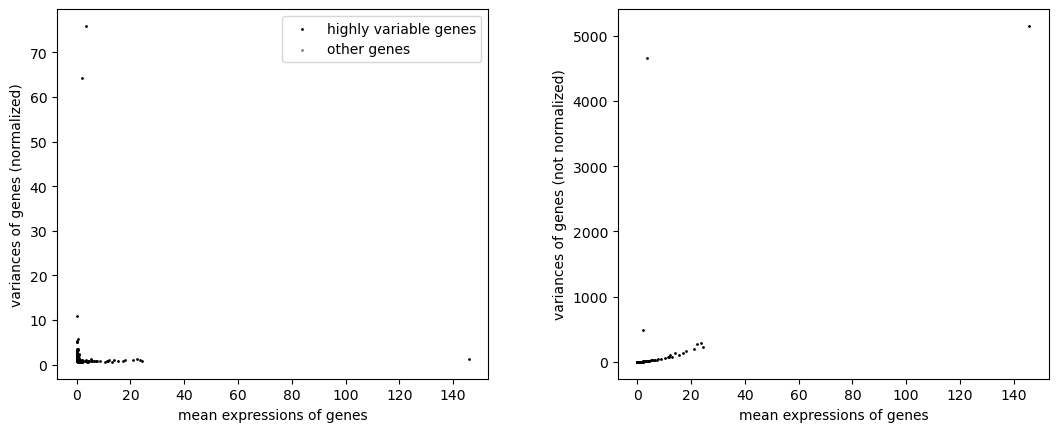

In [19]:
#sc.pp.highly_variable_genes(B_adata,min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(B_adata,
                            n_top_genes=2000,
                            subset=True,
                            layer="counts",
                            flavor="seurat_v3"
                           )
sc.pl.highly_variable_genes(B_adata)

In [21]:
B_adata.raw = B_adata

B_adata = B_adata[:, B_adata.var.highly_variable]
sc.pp.regress_out(B_adata, ['total_counts'])
sc.pp.scale(B_adata, max_value=10)

In [22]:
sc.tl.pca(B_adata, svd_solver='arpack')

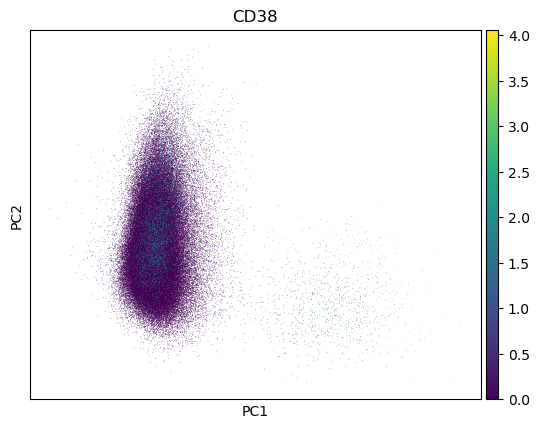

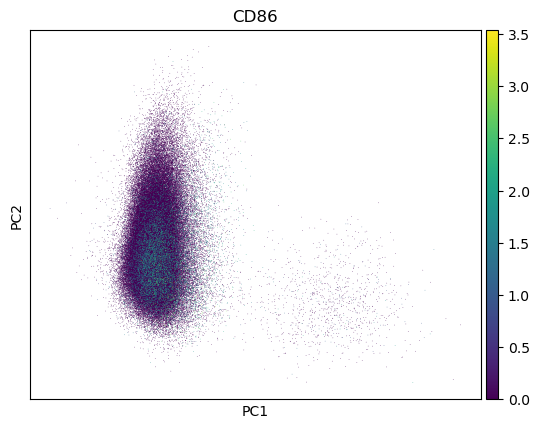

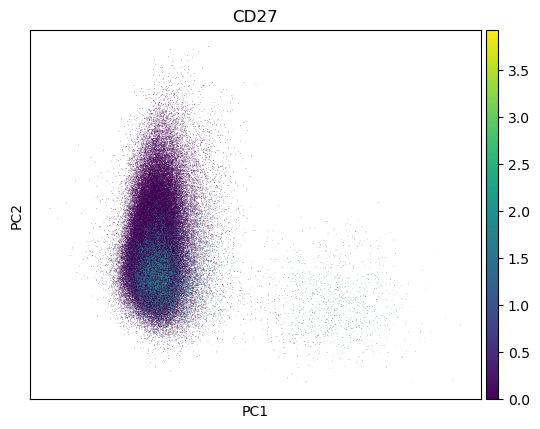

In [23]:
sc.pl.pca(B_adata, color='CD38')
sc.pl.pca(B_adata, color='CD86')
sc.pl.pca(B_adata, color='CD27')

Hmmmm a little worried that these plots aren't showing much

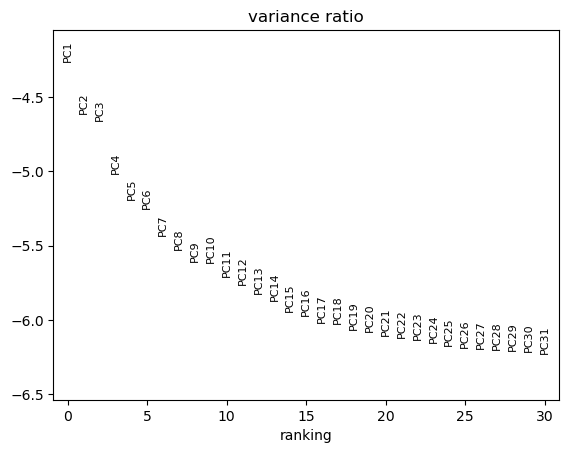

In [24]:
sc.pl.pca_variance_ratio(B_adata, log=True)

In [25]:
sc.pp.neighbors(B_adata, n_neighbors=10, n_pcs=30)

/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
sc.tl.paga(B_adata)
sc.pl.paga(B_adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(B_adata, init_pos='paga')

In [27]:
sc.tl.umap(B_adata)

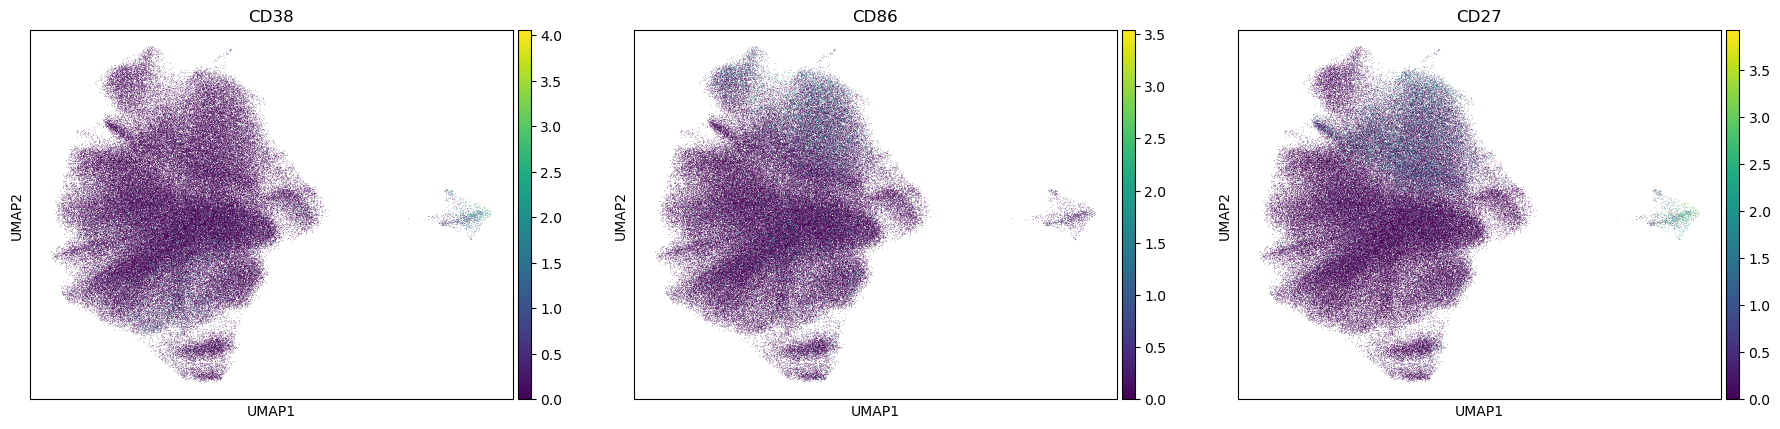

In [28]:
sc.pl.umap(B_adata, color=['CD38', 'CD86', 'CD27'])

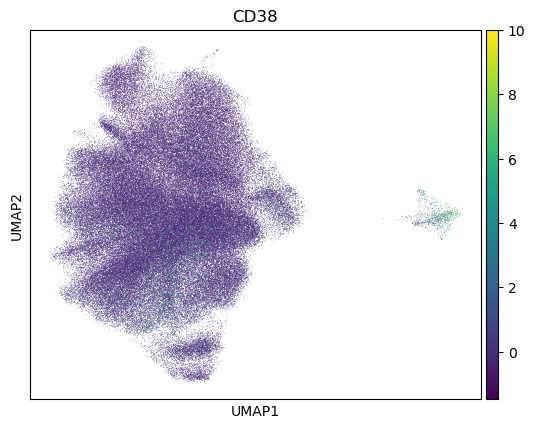

In [29]:
sc.pl.umap(B_adata, color=['CD38'], use_raw=False)

/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

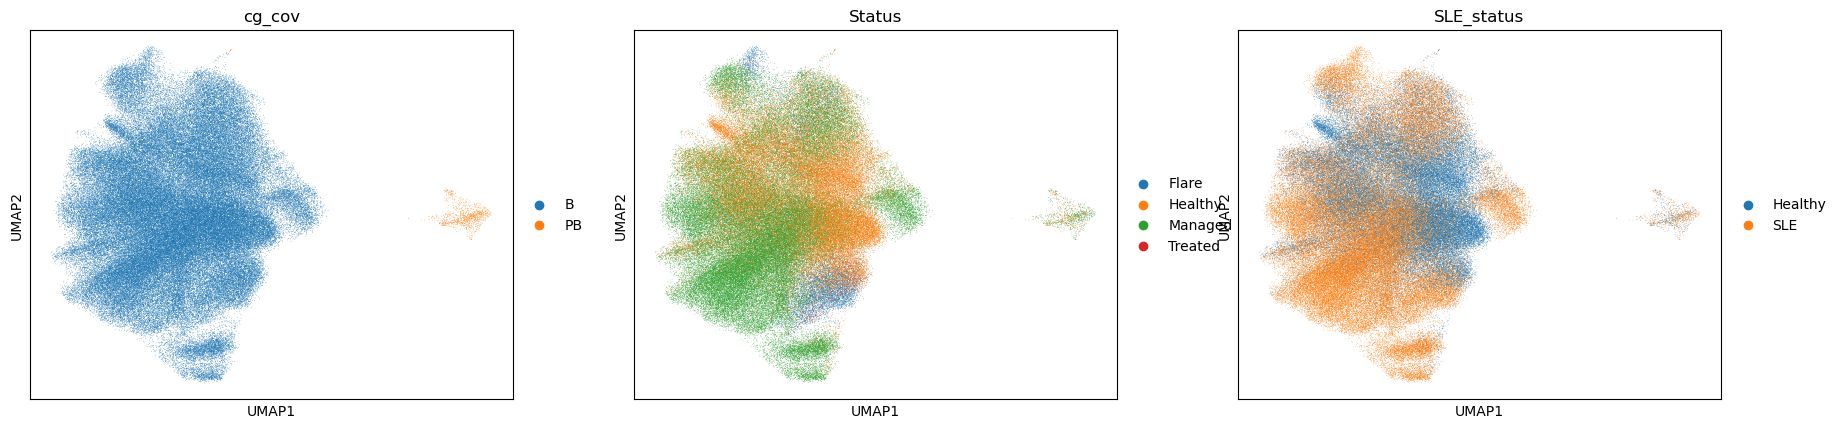

In [30]:
sc.pl.umap(B_adata, color=['cg_cov', 'Status', 'SLE_status'])

/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


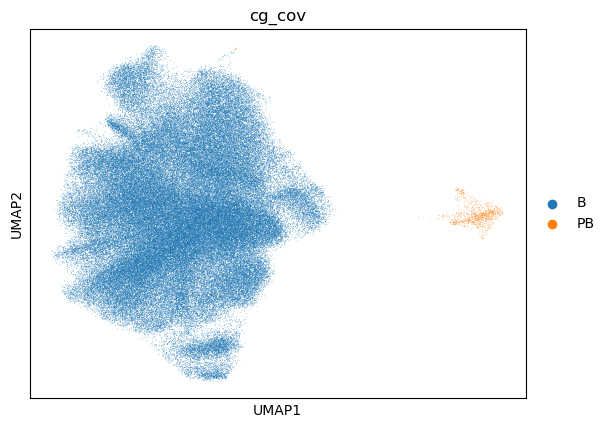

In [31]:
sc.pl.umap(B_adata, color=['cg_cov'])

/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


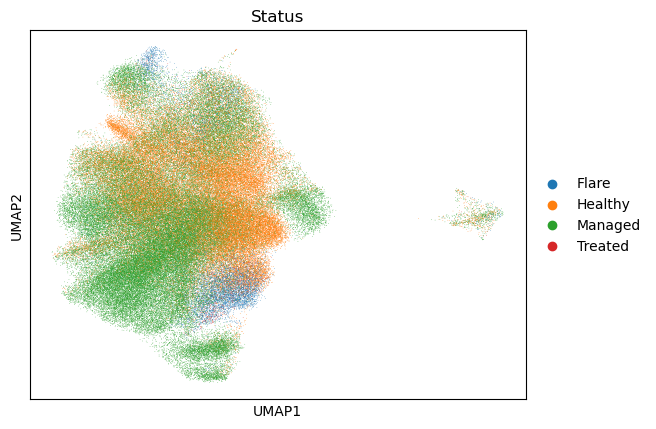

In [32]:
sc.pl.umap(B_adata, color=['Status'])

/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


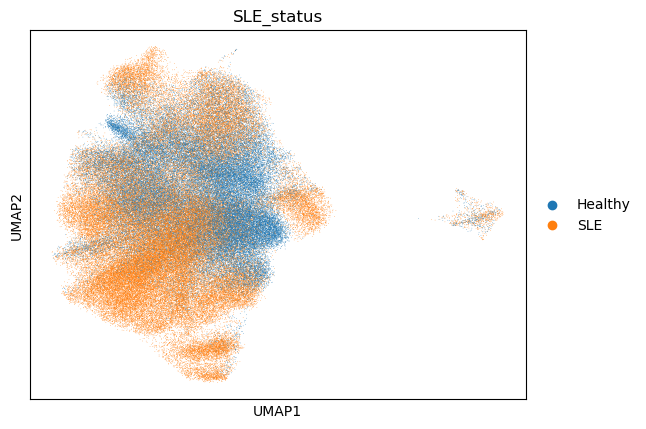

In [33]:
sc.pl.umap(B_adata, color=['SLE_status'])

Clearly the small cluster to the right of the UMAP are the PB...and based on markers I think they are correctly identified

It's very interesting to see parts of the UMAP enriched or flaring patients, healthy patients, managed patients, etc

### Lets's find some clusters

In [34]:
sc.tl.leiden(B_adata)

/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/boss_lab/Apps/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


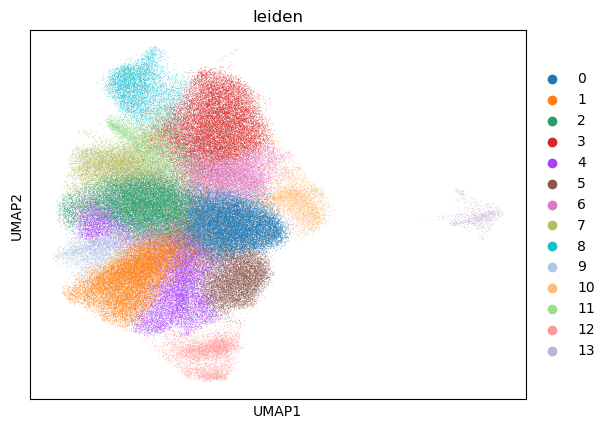

In [35]:
sc.pl.umap(B_adata, color=['leiden'])

## Save AnnData object

In [36]:
B_adata

AnnData object with n_obs × n_vars = 152429 × 1200
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'paga', 'louvain_sizes', 'umap', 'cg_cov_colors', 'Status_colors', 'SLE_status_colors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [37]:
Bfile="Perez_Bcell_v2.h5ad"
#Differences between v1 and v2 is the way I've selected HVG

B_adata_path = os.path.join(data_dir, Bfile)

B_adata.write(B_adata_path)

## Marker Genes for new clusters

/home/boss_lab/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


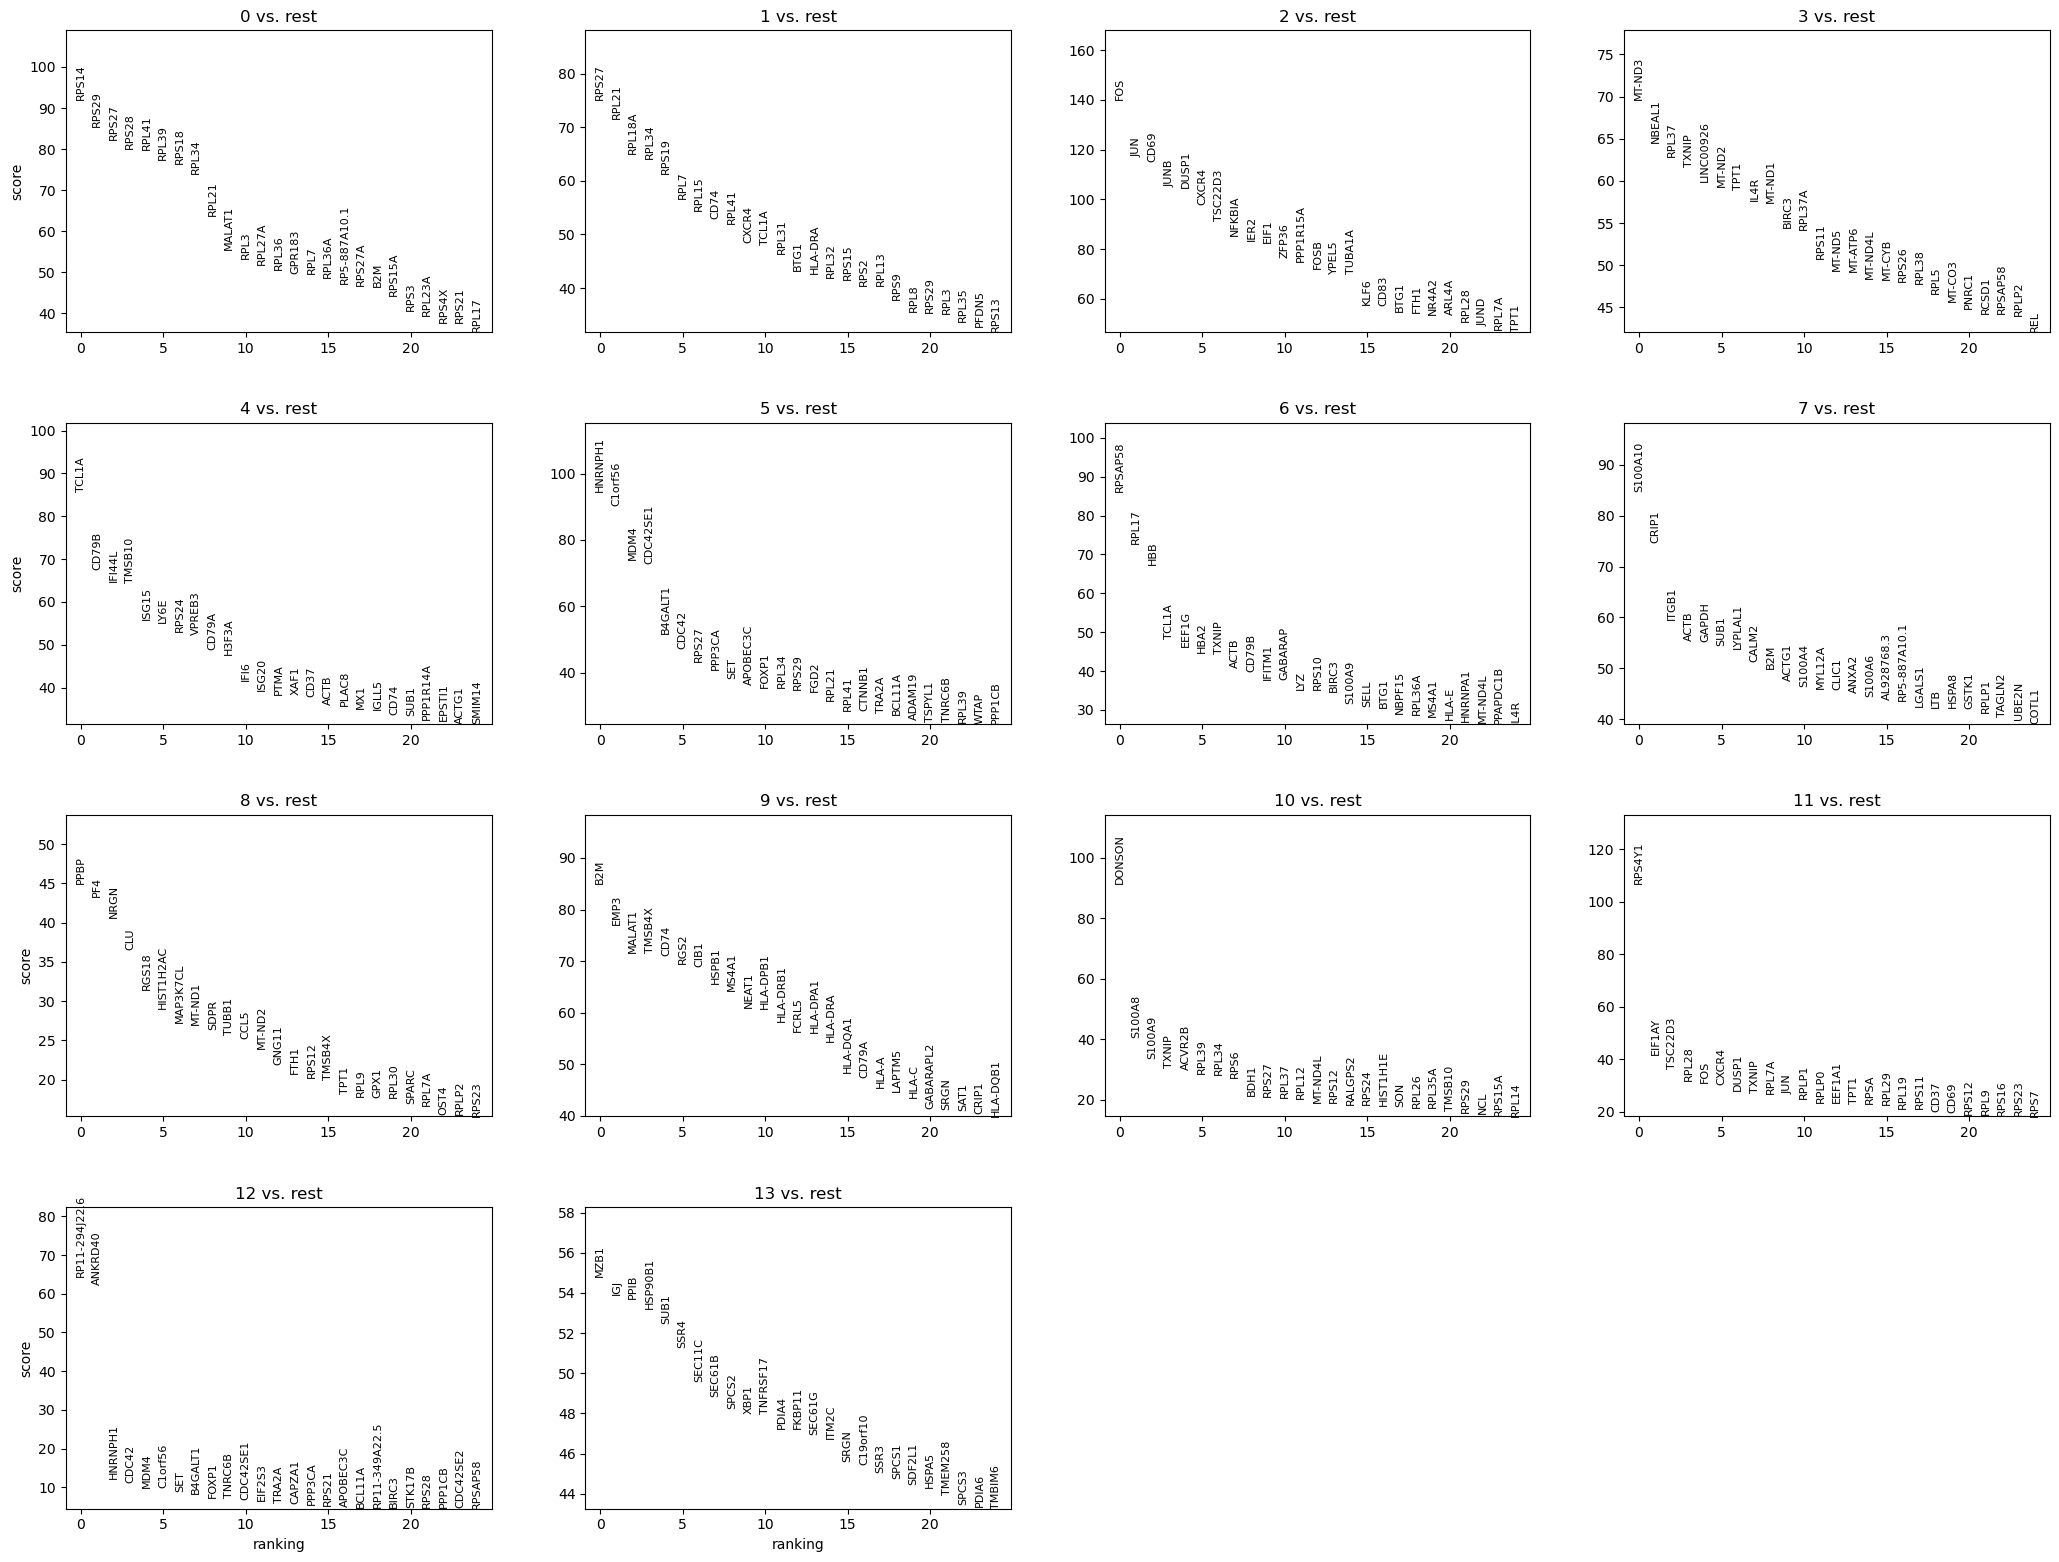

In [36]:
sc.tl.rank_genes_groups(B_adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(B_adata, n_genes=25, sharey=False)

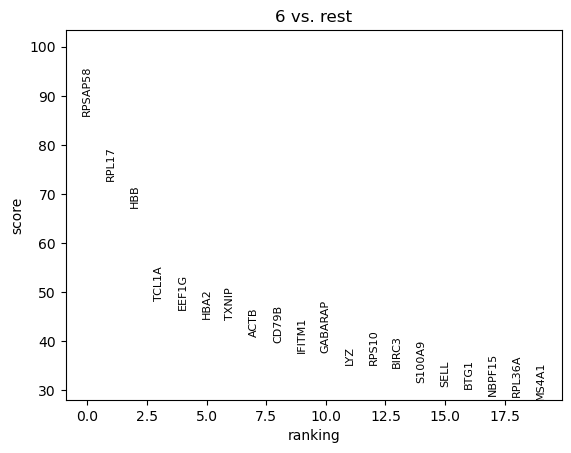

In [37]:
sc.pl.rank_genes_groups(B_adata, groups=['6'], n_genes = 20)

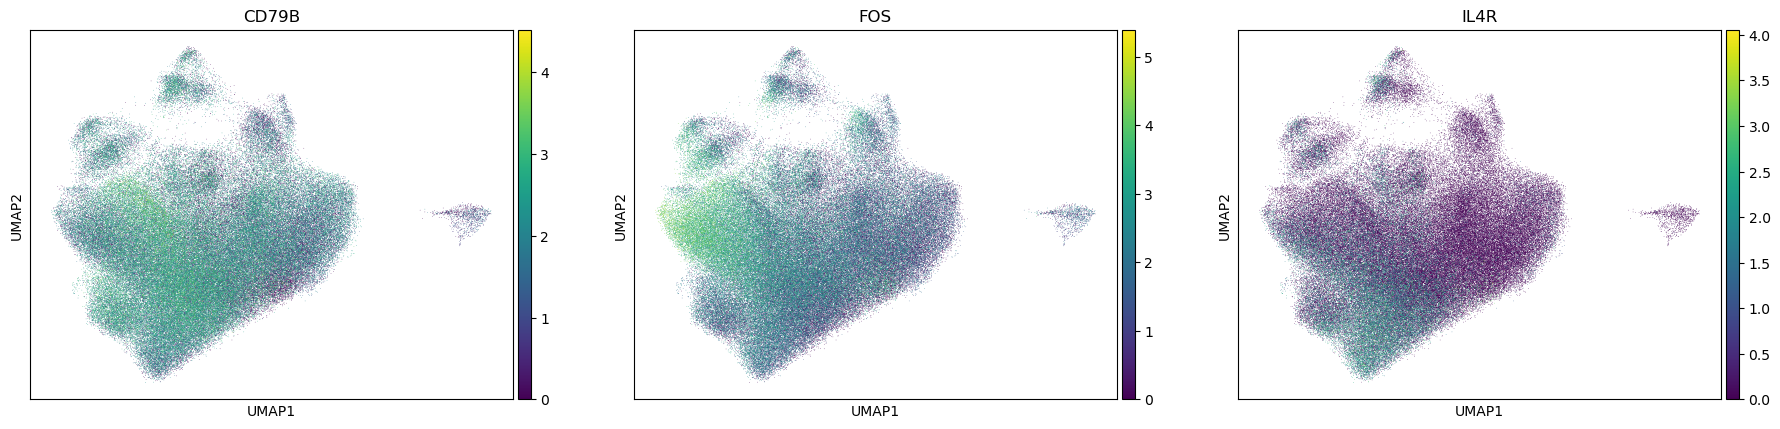

In [39]:
sc.pl.umap(B_adata, color=['CD79B', 'FOS', 'IL4R'])

/home/boss_lab/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/boss_lab/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/boss_lab/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/boss_lab/Apps/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The

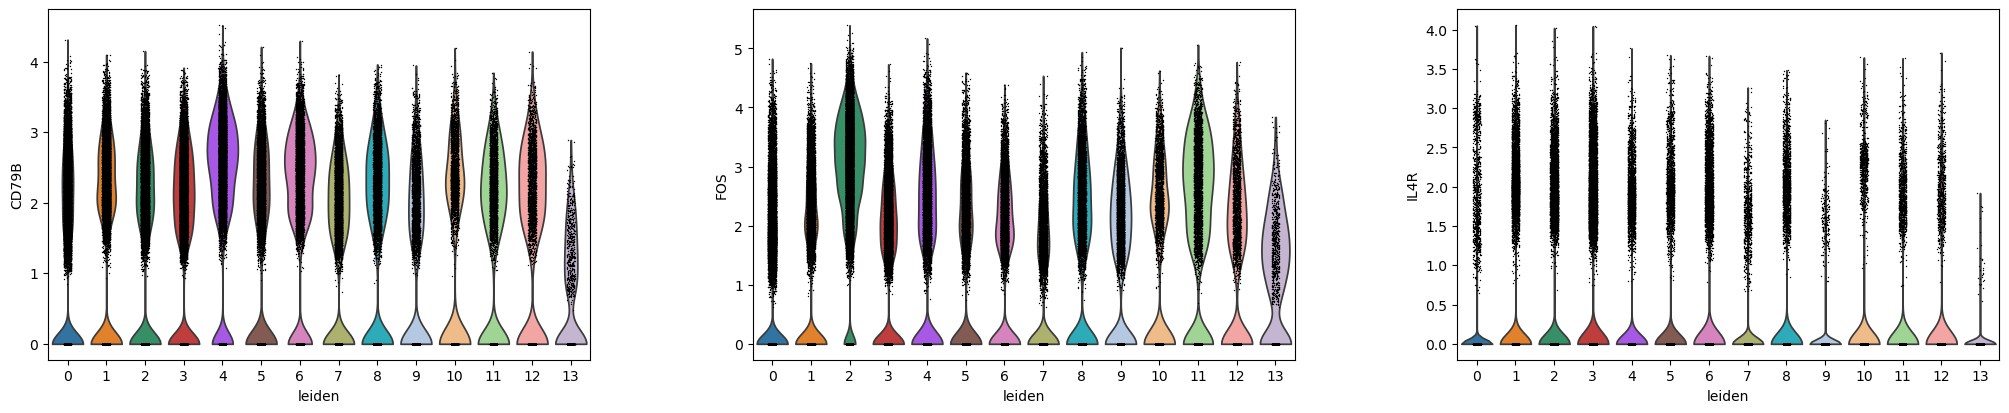

In [40]:
sc.pl.violin(B_adata, ['CD79B', 'FOS', 'IL4R'], groupby='leiden')